In [32]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import alphalens as al
import pickle 
import warnings
import json

from functions.datareader import pull_stock_data, YFinanceReader
from functions.portfolio_optimizer import RiskModelPCA, OptimalHoldings, OptimalHoldingsStrictFactor
from functions.alpha_factor_evaluator import AlphaFactorEvaluator
from functions.indicators import TechnicalIndicators

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
# define all parameters
START_DATE = dt.date(2015, 1, 1)

<h1 style="color:turquoise">Load data from local</h1>

In [4]:
# sectors
with open('./keys/set_sectors.json') as f:
    sectors = json.load(f)

In [5]:
# price data
raw_df = pd.read_parquet('./data/set')

raw_df.set_index(pd.DatetimeIndex(raw_df.index))
raw_df.index.name = 'date'
raw_df.tail(2)

,ticker,close,dividends,high,low,open,stock splits,volume
date,,,,,,,,
2023-04-25,WHA,4.42,0.0,4.44,4.38,4.42,0.0,38961400.0
2023-04-26,WHA,4.42,0.0,4.44,4.34,4.42,0.0,50271318.0


In [6]:
# map sector using the sector dict above
vk = [(k, v) for k, v in sectors.items()]
sector_mapper = {sub: s[0]for s in vk for sub in s[1]}
raw_df['sector'] = raw_df['ticker'].map(sector_mapper)

In [7]:
# filter only stocks that exist since our start date
first_date_df = raw_df[['ticker']].reset_index().groupby('ticker').min()
first_date_df['is_available_since_start'] = first_date_df['date'].apply(lambda x: True if x <= START_DATE else False)

available_tickers = first_date_df[first_date_df['is_available_since_start'] == True].reset_index()['ticker']

# create a sector_mapper of available stocks
sector_mapper_available = {s:sector_mapper[s] for s in sector_mapper if s in available_tickers.values}

# filter only selected stocks
selected_df = raw_df.reset_index().merge(available_tickers, left_on = 'ticker', right_on = 'ticker').set_index('date')

# create an OHLCV df in order to calculate technical indicators
ohlcv_df = selected_df[['ticker', 'open', 'high', 'low', 'close', 'volume']]

# create a dataframe of close price
close_df = selected_df[['ticker', 'sector', 'close']]

<h1 style="color:turquoise">Prepare data</h1>

<h3>Technical Indicators</h3>

In [8]:
ti_df = pd.DataFrame()

# * split multi-index dataframe to a dict of which each value represents OHLCV of each stock
for ticker in available_tickers.values:
    ticker_df = ohlcv_df[ohlcv_df['ticker'] == ticker].drop('ticker', axis = 1)
    
    ti = TechnicalIndicators(ticker_df)
    res_dict = dict()
    res_dict['rsi'] = ti.RSI(n = 14)
    res_dict['stochastic_rsi_k'], res_dict['stochastic_rsi_d'] = ti.stochasticRSI(n = 14, k = 3, d = 3)
    res_dict['macd'], res_dict['macd_signal'] = ti.MACD(n_long = 26, n_short = 12)
    res_dict['vol_change_pct'] = ti.volume_change_pct()
    res_dict['overnight_return'] = ti.overnight_return()
    res_dict['cv_ratio'] = ti.candlestick_volume_ratio(mode='whisker')
    res_dict['bollinger_ratio'] = ti.bollinger_ratio(n = 20, k = 2)
    res_df = pd.DataFrame.from_dict(res_dict).reset_index()
    res_df.insert(1, 'ticker', ticker)

    ti_df = ti_df.append(res_df, ignore_index = True)

# * filter date
ti_df = ti_df[ti_df['date'].dt.date >= START_DATE] \
            .set_index(['date', 'ticker'])


In [9]:
ti_df.head(3)

,,rsi,stochastic_rsi_k,stochastic_rsi_d,macd,macd_signal,vol_change_pct,overnight_return,cv_ratio,bollinger_ratio
date,ticker,,,,,,,,,
2015-01-05,AEONTS,35.714196,0.075352,0.025117,-0.060835,0.584415,0.385835,-0.009217,0.000007,0.110592
2015-01-06,AEONTS,33.333333,0.023444,0.032932,-0.179482,0.431635,1.195815,-0.009259,0.000014,0.166329
2015-01-07,AEONTS,25.000061,0.000000,0.032932,-0.239271,0.297454,0.279924,0.004608,0.000014,0.224731


<h3>Trailing 5-Day Return</h3>

In [12]:
N_FORWARD = 5
return_col_name = f'forward_return_{N_FORWARD}_day'
daily_return_df = close_df.pivot(columns = 'ticker', values = 'close').pct_change(N_FORWARD).shift(-N_FORWARD).mul(100)

# * filter date
daily_return_df = daily_return_df[daily_return_df.index.date >= START_DATE].dropna(axis = 0)

# * melt processed dataframe
daily_return_df = pd.melt(daily_return_df.reset_index(), id_vars='date', value_name=return_col_name, var_name='ticker')
daily_return_df.set_index(['date', 'ticker'], inplace=True)

# TODO: create positive return flag
# we'll frame the problem to be a classification problem with y equals 1 when a stock has positive forward return and 0 otherwise.
daily_return_df[return_col_name] = daily_return_df[return_col_name].apply(lambda x: 1 if x > 0 else 0)
daily_return_df.head()

,,forward_return_5_day
date,ticker,
2015-01-05,AEONTS,1
2015-01-06,AEONTS,1
2015-01-07,AEONTS,1
2015-01-08,AEONTS,1
2015-01-09,AEONTS,1


In [13]:
# TODO: combine x and y
df = ti_df.merge(daily_return_df, left_index=True, right_index=True)

# * map sector
sector_inversed = {v:k for k in sectors for v in sectors[k]}
df['sector'] = df.index.get_level_values(1).map(sector_inversed)

<h2>One-Hot Encode Sector</h2>

In [21]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [15]:
ohe = OneHotEncoder()
ohe.fit(df[['sector']])
sector_dummy = pd.DataFrame(ohe.transform(df[['sector']]).toarray(), columns = ohe.get_feature_names_out(), index = df.index)

In [16]:
df = df.merge(sector_dummy, left_index=True, right_index=True).drop('sector', axis = 1)

# * create month and day of week factors
df['month'] = df.index.get_level_values(0).month
df['day_of_week'] = df.index.get_level_values(0).dayofweek

In [17]:
# # TODO: split data

TRAIN_SIZE = 0.8
dates = sorted(df.index.get_level_values(0))
n_data = len(dates)
train_split = int(TRAIN_SIZE * n_data)
train_dates = dates[:train_split]
test_dates = dates[train_split:]

x_train = df[df.index.isin(train_dates, level=0)]
x_test = df[df.index.isin(test_dates, level=0)]

y_train = x_train.pop(return_col_name)
y_test = x_test.pop(return_col_name)

In [26]:
# Create a LightGBM object
lgb_model = LGBMClassifier()

# Specify the parameter grid to search over
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [10, 20, 30],
              'learning_rate': [0.01, 1],
              'num_leaves': [100, 300, 500],
              'colsample_bytree': [0.5, 0.75]}

# Create a time-series aware cross-validator
cv = TimeSeriesSplit(n_splits=3)

# Create a GridSearchCV object with the specified parameters
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=cv)

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.5, 0.75],
                         'learning_rate': [0.01, 1], 'max_depth': [10, 20, 30],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [100, 300, 500]})

In [27]:
# # TODO: use the best param to train the entire training data
lgb_model = LGBMClassifier(**grid_search.best_params_)
lgb_model.fit(x_train, y_train)


LGBMClassifier(colsample_bytree=0.5, learning_rate=0.01, max_depth=30,
               n_estimators=300, num_leaves=100)

In [36]:
# # TODO: save model
with open(f'model/lgbmclassifier_{dt.date.today()}.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

In [28]:
# # TODO: get training and testing errors
y_train_pred = lgb_model.predict(x_train)
y_pred = lgb_model.predict(x_test)
mse_train = accuracy_score(y_train_pred, y_train)
mse_test = accuracy_score(y_pred, y_test)

print(f'Accuracy on training data: {mse_train:.4f}')
print(f'Accuracy on testing data: {mse_test:.4f}')

Accuracy on training data: 0.6395
Accuracy on testing data: 0.5339


In [29]:
# # * feature importance
importances = pd.Series(lgb_model.feature_importances_, index = lgb_model.feature_name_) \
                .sort_values(ascending=False)
importances

macd_signal                      3643
macd                             3227
bollinger_ratio                  2766
cv_ratio                         2748
rsi                              2747
stochastic_rsi_d                 2551
vol_change_pct                   2511
overnight_return                 2405
stochastic_rsi_k                 2083
month                            1703
day_of_week                       456
sector_banking                    288
sector_consumer_discretionary     285
sector_consumer_staple            273
sector_consumer_finance           266
sector_utilities                  234
sector_real_estate                224
sector_petrochemistry             222
sector_hotel                      206
sector_infrastructure             203
sector_hospital                   202
sector_material                   161
sector_industrial                 155
sector_insurance                  141
dtype: int32

<h1 style="color:blue">Mock Project 7 Starter</h1>

In [ ]:
n_stocks = len(sector_mapper_available)
n_days = len(x_train)

clf_parameters = {
    'criterion': 'squared_error',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 42}
n_trees_l = [50, 100, 250, 500, 1000]

In [ ]:
for c in x_train:
    sum_null = x_train[c].isnull().sum()
    if sum_null > 0:
        print(f'{c}: {sum_null}')

In [ ]:
scores = []
feature_importances = []

for n_trees in n_trees_l:
    clf = RandomForestRegressor(n_trees, **clf_parameters)
    clf.fit(x_train, y_train)
    scores.append({
        'n_tree': n_trees,
        'train': clf.score(x_train, y_train.values),
        'valid': clf.score(x_test, y_test.values),
        'oob': clf.oob_score_
    })

score_df = pd.DataFrame.from_dict(scores) \
            .set_index('n_tree')

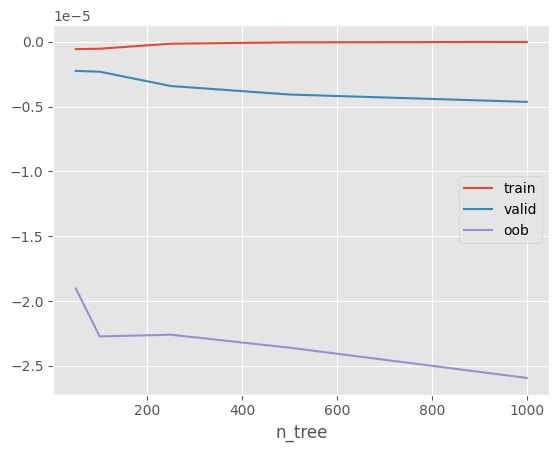

In [ ]:
score_df.plot()
plt.legend(loc='best')

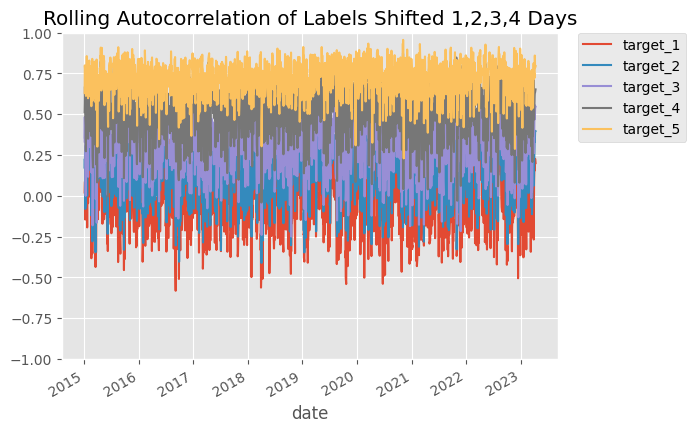

In [ ]:
from scipy.stats import spearmanr


def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]

all_factors = df.copy()
all_factors['target_1'] = all_factors.groupby(level=1)[return_col_name].shift(-5)
all_factors['target_2'] = all_factors.groupby(level=1)[return_col_name].shift(-4)
all_factors['target_3'] = all_factors.groupby(level=1)[return_col_name].shift(-3)
all_factors['target_4'] = all_factors.groupby(level=1)[return_col_name].shift(-2)
all_factors['target_5'] = all_factors.groupby(level=1)[return_col_name].shift(-1)

g = all_factors.dropna().groupby(level=0)
for i in range(5):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, return_col_name, label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()